# Verification of the pipeline on Keras

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_path = os.path.dirname('.')
project_path = os.path.abspath(os.path.join(project_path, '..'))
if not project_path in sys.path:
    sys.path.append(project_path)

keras_contrib_path = os.path.abspath(os.path.join(project_path, 'KerasContrib'))
if not keras_contrib_path in sys.path:
    sys.path.append(keras_contrib_path)


In [3]:
os.environ['KERAS_BACKEND']='tensorflow'

from common.models.keras_unet import get_unet


Using TensorFlow backend.


In [4]:
network_config = {
    'input_shape': (1280, 1920, 3),
    'n_classes': 1,
    'depth': 5,
    'n_filters': 32,
    'verbose': 1,
}
unet = get_unet(**network_config)
unet.summary()

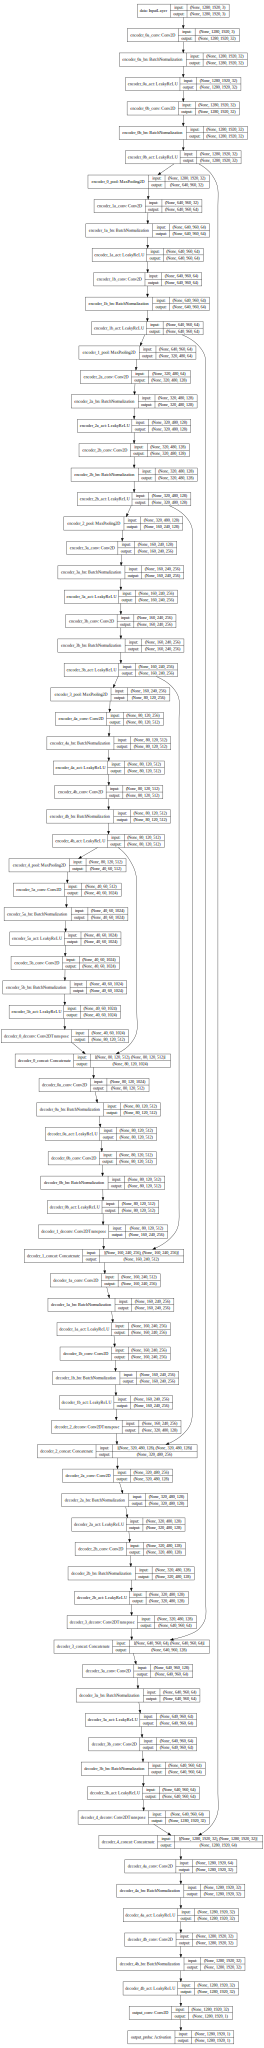

In [28]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(unet, show_shapes=True).create(prog='dot', format='svg'))

In [4]:
import numpy as np
from common.data_utils import train_ids
from common.xy_providers import XYProvider

In [5]:
seed = 123456789
np.random.seed(seed)

check_mode=True

In [6]:
trainval_id_type_list = [(image_id, "Train") for image_id in train_ids]
np.random.shuffle(trainval_id_type_list)

if check_mode:
    trainval_id_type_list = trainval_id_type_list[:20]    


print(len(trainval_id_type_list))

20


In [7]:
from keras_contrib.losses import DSSIMObjective

In [8]:
from common.image_utils import get_image_data

def get_x_data(image_id, image_type, **kwargs):
    img = get_image_data(image_id, image_type, **kwargs)
    return img

def get_y_data(image_id, image_type, **kwargs):
    mask = get_image_data(image_id, image_type + '_mask', **kwargs)
    return mask[:, :, None]

In [10]:
from common.batch_generator import BatchGenerator

In [ ]:
seed = 2017
batch_size = 16
xy_provider = XYProvider(get_x_data=get_x_data, get_y_data=get_y_data, seed=seed)

train_batch_gen = BatchGenerator(batch_size=batch_size,
                                 xy_provider=xy_provider,
                                 phase=BatchGenerator.TRAINING, 
                                 seed=seed)

## Very generic pipeline tryouts

In [10]:
custom_objects = {
    
    'common.models.keras_unet.get_unet': get_unet,
    'DSSIMObjective': DSSIMObjective()
}

In [ ]:
params = {
    
    'xy_provider': XYProvider(get_x_data=get_x_data, get_y_data=get_y_data, seed=seed),    
    
    'random_transform_config': {
        
    }
    
    'standardization_config': {
        
    }
    
    'batch_generator_config': {
        'batch_size': 16,
    }
                       
    'network_config': {
        'input_shape': (1280, 1920, 3),
        'n_classes': 1,
        'depth': 5,
        'n_filters': 32,
        'network': 'common.models.keras_unet.get_unet'
        
        ''
    }

    'training_config': {
        'optimizer': 'adam',
        'loss': 'custom_loss_f'
        'nb_epochs': 30,        
    }
        


#     'normalize_data': True,
#     'normalization': 'vgg',

#     'image_size': (128, 128),

#     'optimizer': 'adam',
#     # Learning rate scheduler
#     'lr_kwargs': {
#         'lr': 0.0001,
#         'a': 0.95,
#         'init_epoch': 0
#     },
#     'lr_decay_f': exp_decay,

#     'EpochValidationCallback_rate': 5,

#     # Reduce learning rate on plateau
#     'on_plateau': True,
#     'on_plateau_kwargs': {
#         'monitor': 'val_loss',
#         'factor': 0.1,
#         'patience': 3,
#         'verbose': 1
#     },

#     'cache': cache,

#     # 'class_index': 0,
#     # 'pretrained_model': 'load_best',
#     # 'pretrained_model': os.path.join(GENERATED_DATA, "weights", ""),

#     'output_path': OUTPUT_PATH,
}

In [ ]:
# if check_mode:
#     params['nb_epochs'] = 2
#     params['batch_size'] = 2

In [9]:
from common.training_utils import cv_training

In [ ]:
cv_training(trainval_id_type_list, )

### Model serialization

In [35]:
from keras.layers import Input, Dense
from keras.models import Model

In [36]:
inputs = Input((100,), name="inputs")
x = Dense(100, name="h1")(inputs)
outputs = Dense(3, name="outputs")(x)
m = Model(inputs=inputs, outputs=outputs)

In [39]:
from keras.optimizers import Adam
from keras import backend as K

optimizer = Adam()

def loss_f(y_true, y_pred):
    t1 = y_true * y_pred
    t1 = K.sum(t1)
    t2 = K.sum(y_true + y_pred)
    return t1 + t2
    
m.compile(optimizer=optimizer, loss=loss_f)

In [48]:
m.save("test_model.h5")

In [51]:
!ls -all test_model.h5

-rw-r--r--  1 vfomin  staff  55408 Aug 12 14:41 test_model.h5


In [49]:
import h5py as h5

In [50]:
with h5.File('test_model.h5', mode='r') as f:
    # instantiate optimizer
    training_config = f.attrs.get('training_config')
    print(training_config)

b'{"metrics": null, "loss": "loss_f", "loss_weights": null, "sample_weight_mode": null, "optimizer_config": {"config": {"lr": -1.4887348482188657e+38, "decay": -35175763279872.0, "beta_1": NaN, "epsilon": 1e-08, "beta_2": -3.2424334164251478e+38}, "class_name": "Adam"}}'


In [52]:
from keras.models import load_model

m2 = load_model('test_model.h5')

ValueError: Unknown loss function:loss_f

### Keras_contrib : extract_image_patches

In [25]:
from keras_contrib import backend as KC
from keras import backend as K

In [21]:
img = get_image_data(*trainval_id_type_list[0])
img.shape

(1280, 1918, 3)

In [34]:
imgs = img.astype(np.float32)[None, :, :, :]
imgs.shape, imgs.dtype

((1, 1280, 1918, 3), dtype('float32'))

In [19]:
import tensorflow as tf

In [36]:
X = K.placeholder(dtype='float32', shape=(1, ) + img.shape)

In [49]:
with tf.Session() as sess:
    p = KC.extract_image_patches(X, ksizes=(256, 256), ssizes=(200, 200))
    results = sess.run(p, feed_dict={X: imgs, Y: 2.0})

In [50]:
results.shape

(1, 7, 10, 256, 256, 3)

In [51]:
import matplotlib.pylab as plt
%matplotlib inline

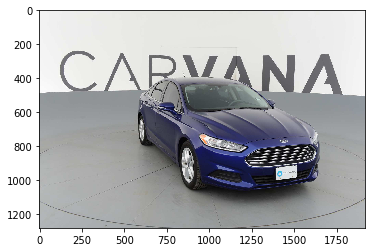

In [52]:
plt.figure()
plt.imshow(img)

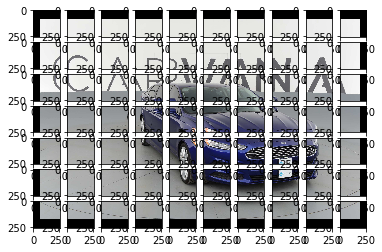

In [53]:
_, ny, nx, _, _, _ = results.shape
plt.figure()
for i in range(ny):
    for j in range(nx):
        plt.subplot(ny, nx, i*nx + j + 1)
        plt.imshow(results[0, i, j, :, :, :].astype(np.uint8))